In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

## Data

In [2]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=64):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test, is_test=True)

Text(0.5, 1.0, '[100] n02110627-affenpinscher')

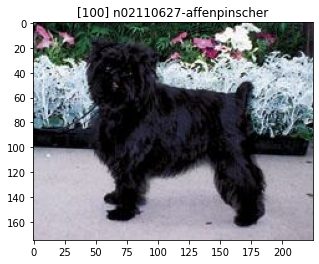

In [4]:
def get_one(ds):
    ds = ds.take(1)
    return list(ds.as_numpy_iterator())[0]

item = get_one(ds_test)
plt.imshow(item['image'])
label = item['label']
plt.title(f'[{label}] {ds_info.features["label"].int2str(label)}')

## CAM

### Model

In [5]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False,
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation="softmax")(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### Train

In [6]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [7]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
188/188 [==============================] - 148s 738ms/step - loss: 3.3025 - accuracy: 0.2762 - val_loss: 6.0947 - val_accuracy: 0.0064
Epoch 2/10
188/188 [==============================] - 137s 730ms/step - loss: 1.2927 - accuracy: 0.6819 - val_loss: 5.2729 - val_accuracy: 0.0064
Epoch 3/10
188/188 [==============================] - 137s 731ms/step - loss: 0.7010 - accuracy: 0.8430 - val_loss: 4.9689 - val_accuracy: 0.0152
Epoch 4/10
188/188 [==============================] - 138s 732ms/step - loss: 0.3952 - accuracy: 0.9358 - val_loss: 3.0067 - val_accuracy: 0.2723
Epoch 5/10
188/188 [==============================] - 137s 732ms/step - loss: 0.2321 - accuracy: 0.9762 - val_loss: 1.4574 - val_accuracy: 0.5907
Epoch 6/10
188/188 [==============================] - 138s 732ms/step - loss: 0.1446 - accuracy: 0.9907 - val_loss: 1.0404 - val_accuracy: 0.6887
Epoch 7/10
188/188 [==============================] - 138s 732ms/step - loss: 0.0980 - accuracy: 0.9960 - val_loss: 0.9880 -

In [8]:
cam_model.save("cam_model.h5")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Evaluate

In [9]:
cam_model = tf.keras.models.load_model("cam_model.h5")
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # cam_model.layers[-3]: GAP 이전 activation layer
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # normalize activation score
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resizing
    return cam_image

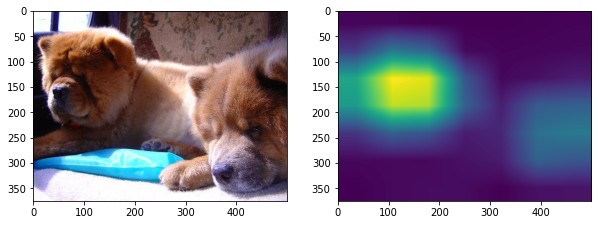

In [11]:
item = get_one(ds_test)

cam_image = generate_cam(cam_model, item)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(item["image"])

plt.subplot(1,2,2)
plt.imshow(cam_image)

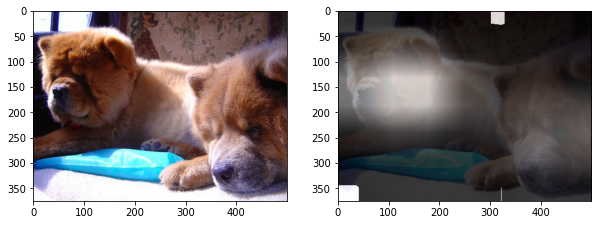

In [12]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image, alpha=0.8)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(origin_image)

plt.subplot(1,2,2)
plt.imshow(blended_image)

- 개가 2마리인데도 각각에 대해 모델이 찾아낸 것 같다.
- 하지만 왜 뒤에 있는 개를 더 뚜렷하게 확인하는지는 잘 모르겠다.

## Grad-CAM

In [13]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

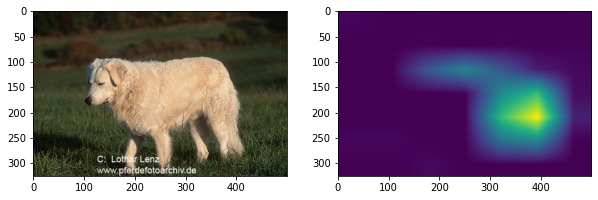

In [14]:
item = get_one(ds_test)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(item["image"])

plt.subplot(1,2,2)
plt.imshow(grad_cam_image)

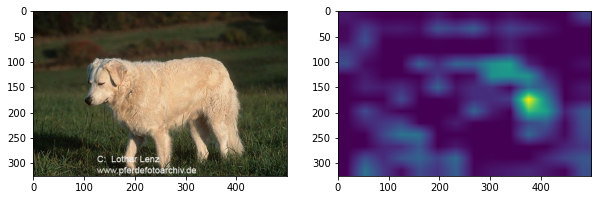

In [15]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(item["image"])

plt.subplot(1,2,2)
plt.imshow(grad_cam_image)

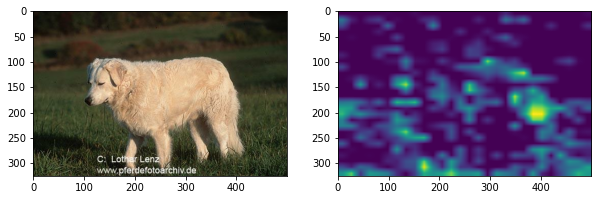

In [16]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(item["image"])

plt.subplot(1,2,2)
plt.imshow(grad_cam_image)

- 입력에 가까운 layer일 수록 물체의 여러 부분을 인지하고, 출력에 가까울수록 뚜렷하게 특정 부분을 인지한다.

## Detection with CAM

In [17]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

item = get_one(ds_test)
cam_image = generate_cam(cam_model, item)
cam_rect = get_bbox(cam_image)
cam_rect

array([[114, 330],
       [114,   0],
       [498,   0],
       [498, 330]])

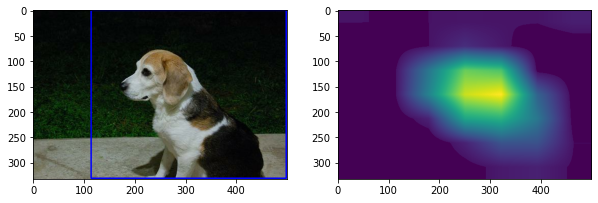

In [18]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [cam_rect], 0, (0,0,255), 2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(cam_image)

### IoU

In [19]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

true_bbox = item['objects']['bbox'][0]
pred_bbox = rect_to_minmax(cam_rect, item['image'])
iou = get_iou(pred_bbox, true_bbox)

print(iou)

0.593631693416021


- 정확도는 낮긴하나 물체의 위치를 찾아낼 수 있다.